In [1]:
from __future__ import division
import numpy as np
import numpy.ma as nma
from pio import imgio
import apply_mask
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import rc
rc('text', usetex=True)
import scipy.ndimage as ndimage

%matplotlib inline

In [2]:
# Image, Velocity & Mask File Definitions
img_file = '../Analysis/test/cam2_still_50a.bsub.img'
W_file = '../Analysis/test/cam2_still_50a.bsub.0032.def.W.npy'
msk_file = '../Analysis/test/cam2_still_50a.bsub.0032.def.mask.npy'
# other files
# time-averaged mask
tave_mask = '../Analysis/test/cam2_still_50a.bsub.0032.def.mask.tave_mask.npy'
# average vertical velocity
avg_W = '../Analysis/test/cam2_still_50a.bsub.0032.def.W.ave.npy'
#fluctuating vertical velocity
flct_W = '../Analysis/test/cam2_still_50a.bsub.0032.def.W.flct.npy'
deltat = 1/300 #s
cal = 1.8e3 #pix/m
D_0 = 0.0508 #m

In [3]:
# load in files
img = imgio.imgio(img_file)
piv = apply_mask.apply_mask(W_file,msk_file)

W_bar = apply_mask.apply_mask(avg_W,tave_mask)
W_prime = apply_mask.apply_mask(flct_W,msk_file)

### Particle Flux

In [4]:
# Average concentration map (aka average of raw images)
light_map = np.loadtxt('../Analysis/test/cam2_ave_lightmap.txt.gz')
I_correction = ndimage.filters.gaussian_filter((np.max(light_map)/light_map),50)
mean_c = img.read_frame2d(0).astype(int)
for f in range(1,img.it):
    t = img.read_frame2d(f)
    t[t<150]=0
    mean_c += t
mean_c = (mean_c / img.it)*I_correction

In [17]:
max_phi = 1e-3
mean_c_phi = mean_c/np.max(mean_c)*max_phi

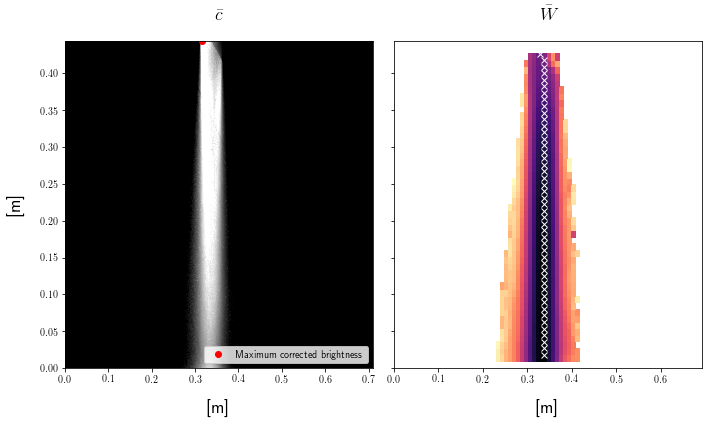

In [5]:
f,ax = plt.subplots(1,2,figsize=(10,6),sharey=True)
X,Z = np.meshgrid(np.linspace(0,img.ix-1,img.ix)/cal, np.linspace(0,img.iy-1,img.iy)/cal)
ax[0].pcolormesh(X,Z,mean_c,cmap=cm.gray,vmin=1000,vmax=10000);
ax[0].set_title(r'$\bar{c}$',y=1.05,fontsize=18);
Xv,Zv = np.meshgrid(np.linspace(0,W_bar.shape[1]-1,W_bar.shape[1])*16/cal, np.linspace(0,W_bar.shape[0]-1,W_bar.shape[0])*16/cal)
ax[1].pcolormesh(Xv,Zv,W_bar,cmap=cm.magma);
ax[1].plot()
ax[1].set_title(r'$\bar{W}$',y=1.05,fontsize=18);
ax[1].set_xlabel('[m]',labelpad=15,fontsize=18)
ax[0].set_xlabel('[m]',labelpad=15,fontsize=18)
ax[0].set_ylabel('[m]',labelpad=15,fontsize=18)
ax[0].set_ylim(0,np.max(Z))
plt.tight_layout()
centerline = np.zeros((2,W_bar.shape[0]))
for r in range(0,W_bar.shape[0]):
    centerline[0,r] = r
    try:
        centerline[1,r] = (np.where(W_bar[r,:] == nma.min(W_bar[:,:],axis=1)[r])[0])
    except:
        centerline[1,r] = np.nan
centerline_pix = (centerline*16+16.5)
Z = (800-centerline_pix[0])/cal/D_0
#R = 
ax[1].plot(centerline_pix[1]/cal,centerline_pix[0]/cal,'wx');
ax[0].plot(np.where(mean_c==np.max(mean_c))[1]/cal,np.where(mean_c==np.max(mean_c))[0]/cal,'ro')
ax[0].legend(['Maximum corrected brightness'],loc=4);

In [18]:
# calculate mean concentration on PIV grid
c_map = np.zeros(W_bar.shape)
c_map2 = np.zeros(W_bar.shape)
mean_c2 = mean_c/I_correction
for r in range(8,img.iy-8,16):
    for c in range(8,img.ix-8,16):
        #print int(r/16),int(c/16) 
        c_map[int(r/16),int(c/16)] = np.mean(mean_c_phi[slice(r,r+16,1),slice(c,c+16,1)])
        #c_map2[int(r/16),int(c/16)] = np.mean(mean_c2[slice(r,r+16,1),slice(c,c+16,1)])

In [12]:

W_plume=nma.masked_greater(W_bar,-4.5)
(c_map[:,0:38]).max()

15321.226453638259

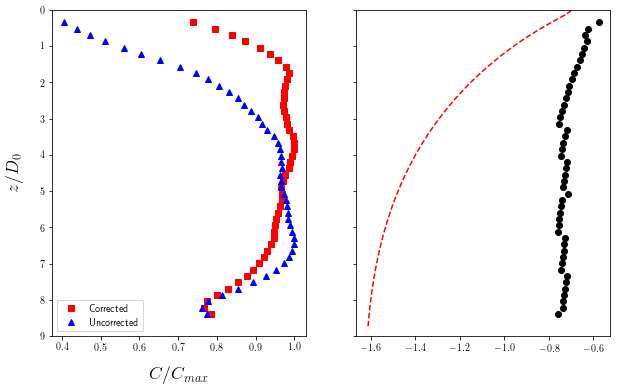

In [114]:
centerline = np.zeros((2,W_bar.shape[0]))
for r in range(0,W_bar.shape[0]):
    centerline[0,r] = r
    try:
        centerline[1,r] = (np.where(W_bar[r,:] == nma.min(W_bar[:,:],axis=1)[r])[0])
    except:
        centerline[1,r] = np.nan
centerline_pix = (centerline*16+16.5)
Z = (800-centerline_pix[0])/cal/D_0
#centerline concentration and velocity
f,ax = plt.subplots(1,2,figsize=(10,6),sharey=True)
#ax[0].plot(c_map[centerline[0][1:-1].astype('int'),
#                 centerline[1][1:-1].astype('int')]/np.max(c_map),Z[1:-1],'rs',
#          c_map2[centerline[0][1:-1].astype('int'),
#                 centerline[1][1:-1].astype('int')]/np.max(c_map2),Z[1:-1],'b^')
ax[0].plot(np.sum(c_map,axis=1)[1:-1]/np.max(np.sum(c_map,axis=1)[1:-1]),Z[1:-1],'rs',
          np.sum(c_map2,axis=1)[1:-1]/np.max(np.sum(c_map2,axis=1)[1:-1]),Z[1:-1],'b^')
ax[0].legend(['Corrected','Uncorrected'])
ax[0].set_xlabel('$C/C_{max}$',labelpad=15,fontsize=18)
ax[0].set_ylabel('$z/D_0$',labelpad=15,fontsize=18)
ax[0].set_ylim(9,0);

ax[1].plot(nma.mean(W_plume[:,:],axis=1)/cal/deltat/2,Z,'ko')
#ax[1].plot(np.polyval(np.polyfit(Z[35:-1],nma.min(W_bar[:,:],axis=1)[35:-1].data,1)/cal/deltat,Z[35:-1]),Z[35:-1],'g-',linewidth=4)
#ax[1].text(-1.9,1.5,r'$\frac{dw_z}{dz}=-7.8$ [1/s]',fontsize=15,color='darkgreen')
#ax[1].set_xlabel('$W_c$ [m/s]',labelpad=15,fontsize=18);
ax[1].plot(-wp[0:-1],np.linspace(0,799,steps)/cal/D_0,'r--');

# Calculation of:
# $\overline{wc} = \bar{w}\bar{c} + \overline{w^{\prime}c^{\prime}}$

In [29]:
WC = np.zeros(piv.shape)
WpCp = np.zeros(piv.shape)
I_max = 0
for f in range(1,piv.shape[0]):
    C = img.read_frame2d(f)*I_correction
    cf = C - mean_c
    temp=np.zeros(W_bar.shape)
    temp2=np.zeros(W_bar.shape)
    temp3=np.zeros(W_bar.shape)
    for r in range(8,img.iy-8,16):
        for c in range(8,img.ix-8,16):
            #print int(r/16),int(c/16)
            temp[int(r/16),int(c/16)] = np.mean(C[slice(r,r+16,1),slice(c,c+16,1)])
            temp2[int(r/16),int(c/16)] = np.mean(cf[slice(r,r+16,1),slice(c,c+16,1)])
            temp3[int(r/16),int(r/16)] = np.mean(C[slice(r,r+16,1),slice(c,c+16,1)])
    if np.max(temp)> I_max:
        I_max = np.max(temp)
    temp = temp/I_max
    temp2 = temp2/I_max
    WpCp[f,:,:] = temp2*-W_prime[f]/cal/deltat
    WC[f,:,:] = temp*(-piv[f]/cal/deltat)
#del temp, C    

In [30]:
temp2.min()

-0.38088386800791385

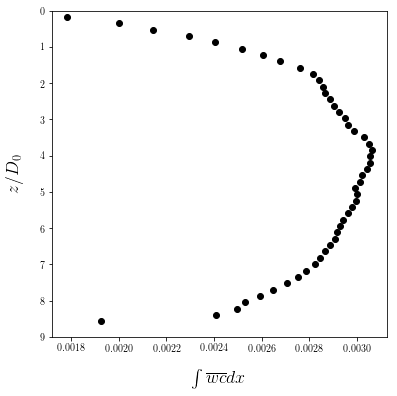

In [31]:
WC_bar = np.mean(WC,axis=0)
f,ax = plt.subplots(figsize=(6,6))
ax.plot(np.trapz(WC_bar,dx=1/cal,axis=1),Z,'ko')
ax.set_ylim(9,0);
ax.set_xlabel(r'$\int{\overline{wc}}dx$',labelpad=15,fontsize=18)
ax.set_ylabel('$z/D_0$',labelpad=15,fontsize=18);

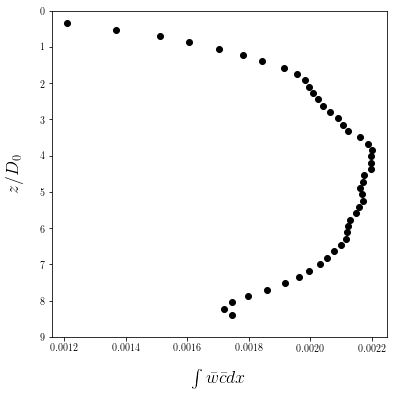

In [40]:

f,ax = plt.subplots(figsize=(6,6))
ax.plot(np.trapz((c_map/I_max)*-W_bar/cal/deltat,dx=1/cal,axis=1),Z,'ko')
ax.set_ylim(9,0);
ax.set_xlabel(r'$\int{\bar{w} \bar{c}}dx$',labelpad=15,fontsize=18)
ax.set_ylabel('$z/D_0$',labelpad=15,fontsize=18);

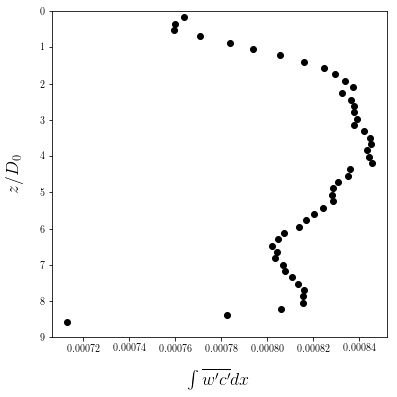

In [36]:
WpCp_bar = np.mean(WpCp,axis=0)
f,ax = plt.subplots(figsize=(6,6))
ax.plot(np.trapz(WpCp_bar,dx=1/cal,axis=1),Z,'ko')
ax.set_ylim(9,0);
ax.set_xlabel(r'$\int{\overline{w^{\prime}c^{\prime}}}dx$',labelpad=15,fontsize=18)
ax.set_ylabel('$z/D_0$',labelpad=15,fontsize=18);

In [23]:
C = img.read_frame2d(0)*I_correction
cf = C - mean_c

# Plume classification through the Gamma function

In [177]:
r = np.arange(8,38*16,16).reshape(1,38)
r = r.repeat(W_plume.shape[0],axis=0)
JQ = abs(2*np.pi*np.sum(W_plume[:,0:38]*r,axis=1))
JM = abs(2*np.pi*np.sum(W_plume[:,0:38]**2*r,axis=1))
JB = abs(2*np.pi*np.sum(W_plume[:,0:38]*(((1-c_map[:,0:38])*1.225 + c_map[:,0:38]*2500)-1)*r,axis=1))
Q = JQ/np.pi
M = 2*JM/np.pi
F = 2*JB/np.pi
alpha = 0.03
Gamma = (5*Q**2*F)/(4*alpha*M**(5/2))
Gamma[14:30]=Gamma[14:30]-(Gamma[14]-Gamma[13])+np.mean(np.gradient(Gamma[0:13]))
Gamma[30]=Gamma[30]-(Gamma[30]-Gamma[29])+np.mean(np.gradient(Gamma[14:29]))
Gamma[31:]=Gamma[31:]-(Gamma[31]-Gamma[30])+np.mean(np.gradient(Gamma[14:30]))

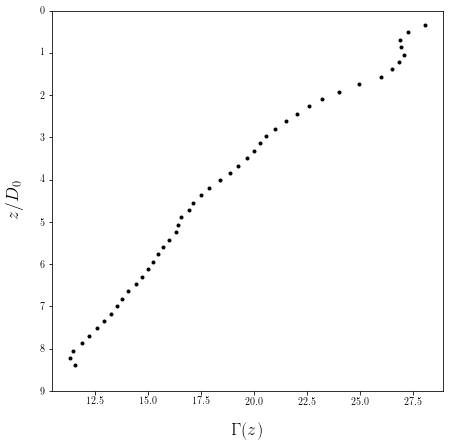

In [180]:
f,ax = plt.subplots(figsize=(7,7))
ax.plot(Gamma,Z,'k.')
ax.set_ylim(9,0);
ax.set_xlabel('$\Gamma (z)$',labelpad=15,fontsize=18)
ax.set_ylabel('$z/D_0$',labelpad=15,fontsize=18);

# Liu's Numerical Model for Particle Plumes

In [58]:
beta_0 = 1e-3 # volume fraction
rho_p = 2500 # kg/m^3
rho_a = 1.225 # kg/m^3
g = 9.81 # m/s^2
w_0 = .7 # m/s
r_0 = .0508/2 # m
dp = 52e-6 #m
tau_p = 17e-3 # s
mu_a = 1.825e-5 # kg m^-1 s^-1


steps = 10000
s = np.arange(0,800,800/steps)
s_size = np.diff(np.arange(1,800,800/steps))[0]
w_a0 = w_0-(tau_p*g)
r_a0 = r_0
alpha = 0.03
Q_a0 = np.pi*r_a0**2*w_a0
M_a0 = w_a0*Q_a0*rho_a
m_dot = 5.8e-3 # kg/s


B = (rho_p - rho_a)*np.pi*g*beta_0*w_0*r_0**2
K1 = 15/2*np.pi*beta_0*w_0*r_0**2*rho_a**(-1/3)*mu_a**(2/3)*dp**(-5/3)


In [66]:
wp = np.zeros((steps+1,))
wa = np.zeros((steps+1,))
Qa = np.zeros((steps+1,))
Ma = np.zeros((steps+1,))
ra = np.zeros((steps+1,))
wp[0] = w_0
wa[0] = w_a0
Qa[0] = Q_a0
ra[0] = r_0
Ma[0] = M_a0
C = np.zeros((steps+1))
C = 1

for i,ii in enumerate(s):
    i=i+1
    ii=ii+s_size
    Rep = (rho_a*(wp[i-1]-wa[i-1])*dp)/mu_a
    Cd = 24*(1+0.15*Rep**.687)/Rep
    Fd = rho_a*(wp[i-1]-wa[i-1])**2/2*Cd/4*np.pi*dp**2*C*6*beta_0*w_0*r_0**2/dp**3
    wp[i] = wp[i-1] + s_size/cal * (B-Fd)/(m_dot*wp[i-1])
    Qa[i] = Qa[i-1] + s_size/cal * (2*np.pi*ra[i-1]*wa[i-1]*alpha)
    Ma[i] = Ma[i-1] + s_size/cal * (Fd)/wp[i-1]
    wa[i] = Ma[i]/(Qa[i]*rho_a)
    ra[i] = np.sqrt(Ma[i]/(np.pi*wa[i]))
    #print wp[i],Qa[i],Ma[i],wa[i],ra[i],'\n'

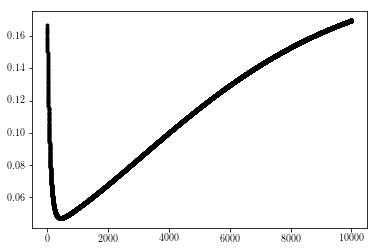

In [67]:
plt.plot(wp-wa,'k.')

In [19]:
i=1
Rep = (rho_a*(wp[i-1]-wa[i-1])*dp)/mu_a
Cd = 24/Rep*(1+0.15*(Rep**.687))
Fd = rho_a*(wp[i-1]-wa[i-1])**2/2*Cd/4*np.pi*dp**2*C*6*beta_0*w_0*r_0**2/dp**3
F2 = K1*(wp[i-1]-wa[i-1]**(4/3)*C)
print Fd/C, F2/C, B-Fd, B-F2

0.0566393606186072 0.02336660901611116 0.005465197853457539 0.038737949455953574
